Question 1: [IPO] Withdrawn IPOs by Company Type

In [2]:
import ssl
import pandas as pd
from urllib.request import urlopen
import time
import urllib.request
from urllib.error import HTTPError, URLError

In [3]:
def get_table(url):
    # Create SSL context for https
    context = ssl._create_unverified_context()
    
    # Set up headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        # Create a Request object with headers
        req = urllib.request.Request(url, headers=headers)
        
        # Open URL with SSL context
        with urllib.request.urlopen(req, context=context) as response:
            # Add a small delay to be respectful to the server
            time.sleep(1)
            
            # Read the HTML content
            html = response.read()
            
            # Parse tables from HTML
            tables = pd.read_html(html)
            
            if len(tables) > 0:
                return tables[0]
            else:
                print("No tables found in the webpage")
                return None
                
    except HTTPError as e:
        print(f"HTTP Error: {e.code} - {e.reason}")
        return None
    except URLError as e:
        print(f"URL Error: {e.reason}")
        return None
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None




In [4]:
# URL for withdrawn IPOs
url = "https://stockanalysis.com/ipos/withdrawn/"

# Fetch the data
df = get_table(url)

# Check if the DataFrame is not None and print its length
print(f'total number of withdrawn IPOs: {len(df)}' if df is not None else 'No data retrieved.')

# Display the first few rows of the DataFrame
df.head()

total number of withdrawn IPOs: 100


,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


In [5]:
# Classify companies based on their names without using numpy
def classify_company(name):
    name_lower = name.lower()
    if "acquisition" in name_lower:
        return "Acq.Corp"
    elif "inc." in name_lower:
        return "Inc"
    elif "group" in name_lower:
        return "Group"
    elif "holdings" in name_lower:
        return "Holdings"
    elif "ltd" in name_lower:
        return "Ltd"
    elif "limited" in name_lower:
        return "Ltd"
    else:
        return "Other"



In [6]:
result = df["Company Name"].apply(classify_company)
result
# Assign the result to a new column in the DataFrame
df["Company Class"] = result
# Display unique values in the "Company Class" column
set(df["Company Class"].values)

{'Acq.Corp', 'Group', 'Holdings', 'Inc', 'Ltd', 'Other'}

In [7]:
import numpy as np
# Parse the "Price Range" column to extract average price
def parse_price_range(price_range):
    # Check if the price range is a string and contains a dash
    if isinstance(price_range, str) and "-" in price_range:
        parts = price_range.replace("$", "").split(" - ")
        try:
            numbers = [float(p.strip()) for p in parts if p.strip().replace('.', '', 1).isdigit()]
            if len(numbers) == 2:
                return np.mean(numbers)
        except Exception:
            # If there's an error in conversion, return NaN
            return np.nan
    # If the price range is a single value, convert it to float
    elif isinstance(price_range, str) and price_range.startswith("$"):
        return float(price_range.replace("$", "").strip())
    # If the price range is not valid, return NaN
    return np.nan

df["Price Avg"] = df["Price Range"].apply(parse_price_range).replace(np.nan, 0)

df.head(8)

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Price Avg
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc,0.0
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc,3.5
2,AURN,"Aurion Biotech, Inc.",-,-,Inc,0.0
3,ROTR,"PHI Group, Inc.",-,-,Inc,0.0
4,ONE,One Power Company,-,-,Other,0.0
5,HPOT,The Great Restaurant Development Holdings Limited,$4.00 - $6.00,1400000,Holdings,5.0
6,CABR,"Caring Brands, Inc.",$4.00,750000,Inc,4.0
7,SQVI,"Sequoia Vaccines, Inc.",$8.00 - $10.00,2775000,Inc,9.0


In [8]:
# Parse the "Shares Offered" column to clean and convert it to float
df["Shares Offered Clean"] = (
	df["Shares Offered"]
	.replace("-", np.nan)
	.str.replace(",", "")
	.astype(float)
.replace(np.nan, 0))


In [9]:
df["Withdraw Value"] = (df["Shares Offered Clean"] * df["Price Avg"])

print(f'Total Record Withdraw Value greater than 0: {len(df[df["Withdraw Value"] > 0])}')
df[df["Withdraw Value"] > 0]

Total Record Withdraw Value greater than 0: 71


,Symbol,Company Name,Price Range,Shares Offered,Company Class,Price Avg,Shares Offered Clean,Withdraw Value
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc,3.5,2000000.0,7000000.0
5,HPOT,The Great Restaurant Development Holdings Limited,$4.00 - $6.00,1400000,Holdings,5.0,1400000.0,7000000.0
6,CABR,"Caring Brands, Inc.",$4.00,750000,Inc,4.0,750000.0,3000000.0
7,SQVI,"Sequoia Vaccines, Inc.",$8.00 - $10.00,2775000,Inc,9.0,2775000.0,24975000.0
8,SNI,Shenni Holdings Limited,$4.00 - $6.00,3000000,Holdings,5.0,3000000.0,15000000.0
...,...,...,...,...,...,...,...,...
92,DPAC,Deep Space Acquisition Corp. I,$10.00,21000000,Acq.Corp,10.0,21000000.0,210000000.0
93,GIF,"GigCapital6, Inc.",$10.00,20000000,Inc,10.0,20000000.0,200000000.0
94,HYIV,Haymaker Acquisition Corp. IV,$10.00,26100000,Acq.Corp,10.0,26100000.0,261000000.0
97,IFIT,iFIT Health & Fitness Inc.,$18.00 - $21.00,30769231,Inc,19.5,30769231.0,600000004.5


In [10]:
# Group by 'Company Class' and sum the 'Withdraw Value'
withdrawn_value_by_class = df.groupby("Company Class")["Withdraw Value"].sum().sort_values(ascending=False)
withdrawn_value_by_class_formatted = withdrawn_value_by_class.apply(lambda x: f"${x:,.2f}")

# Display the results
print("Withdrawn Value by Company Class:")
print(withdrawn_value_by_class_formatted)

# highest withdrawn value by company class
print(f"\nHighest Withdrawn Value by Company Class: ${withdrawn_value_by_class.max():,.2f}")



Withdrawn Value by Company Class:
Company Class
Acq.Corp    $4,021,000,000.00
Inc         $2,257,164,204.85
Other         $767,919,999.00
Ltd           $321,734,584.75
Holdings      $303,000,000.50
Group          $33,787,500.00
Name: Withdraw Value, dtype: object

Highest Withdrawn Value by Company Class: $4,021,000,000.00


Question 2: [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


In [11]:
url = "https://stockanalysis.com/ipos/2024/"

# Fetch the data
ipo_data = get_table(url)


In [12]:
ipo_data["IPO Date cleaned"] = pd.to_datetime(ipo_data["IPO Date"])

ipo_data_cleaned = ipo_data[(ipo_data["IPO Date cleaned"] < "2024-06-01") & (ipo_data["IPO Price"] != '-')]


In [13]:
# print the number of records in the cleaned DataFrame
print(f'Total number of IPOs before cleaning: {len(ipo_data)}')
print(f'Check data quality: {ipo_data_cleaned.isnull().sum()}')
print(f'Total number of IPOs after cleaning: {len(ipo_data_cleaned)}')

Total number of IPOs before cleaning: 225
Check data quality: IPO Date            0
Symbol              0
Company Name        0
IPO Price           0
Current             0
Return              0
IPO Date cleaned    0
dtype: int64
Total number of IPOs after cleaning: 75


In [14]:
# Calculate growth and volatility for a given ticker
def calc_growth(ticker, data, period_days):
    r = data[ticker][data.index >= data[ticker].first_valid_index()]
    #print(f"Calculating growth for {ticker} over the last {period_days} days.")
    try:
        return r[period_days] /r[0]
    except IndexError:
        #print(f"IndexError: {ticker} does not have enough data for the specified period.")
        return None

def calc_voltatility(ticker, data, volatility_date):
    tr = data[ticker][data.index >= data[ticker].first_valid_index()]
    r = tr.rolling(30).std() * np.sqrt(252)

    return r[r.index == volatility_date].values[0]

In [15]:
import yfinance as yf
#get data from yahoo finance
index_tickers = dict(zip(ipo_data_cleaned['Company Name'], ipo_data_cleaned['Symbol'])) 

tickers = list(index_tickers.values())
history_data = yf.download(tickers=tickers, interval='1d',period='max')['Close']

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  75 of 75 completed


In [16]:
history_data

Ticker,AHR,ALAB,ANRO,AS,AUNA,AVBP,BKHA,BOLD,BOW,BTOC,...,UBXG,ULS,UMAC,VHAI,VIK,YIBO,YYGH,ZBAO,ZK,ZONE
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-09,35.200001,92.349998,2.54,37.669998,6.360,23.600000,10.60,1.10,35.310001,1.39,...,3.37,70.550003,9.18,0.0006,48.880001,1.39,1.250,1.099,26.170000,3.89
2025-06-10,35.250000,91.459999,2.64,37.840000,6.350,24.500000,10.60,1.07,34.919998,1.57,...,3.37,70.139999,8.95,0.0006,48.750000,1.38,1.440,1.080,26.240000,3.79
2025-06-11,35.900002,94.540001,2.50,37.740002,6.240,23.285000,10.64,1.06,35.009998,1.52,...,3.26,70.449997,7.98,0.0006,47.360001,1.40,1.750,0.990,26.510000,3.72


In [17]:
voltatility_date = '2025-06-06'
# Calculate growth for a given ticker
for i in [1, 3, 7, 30, 90, 252]:
    ipo_data_cleaned[f'growth_{i}d'] = ipo_data_cleaned['Symbol'].apply(lambda x: calc_growth(x, history_data, i))

# Calculate volatility for a given ticker
ipo_data_cleaned['volatility'] = ipo_data_cleaned['Symbol'].apply(lambda x: calc_voltatility(x, history_data, voltatility_date))

#calculate sharpe ratio
ipo_data_cleaned['Sharpe Ratio'] = (ipo_data_cleaned['growth_252d'] - 0.045) / ipo_data_cleaned['volatility']

/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/4272347931.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return r[period_days] /r[0]
/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/2732960070.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipo_data_cleaned[f'growth_{i}d'] = ipo_data_cleaned['Symbol'].apply(lambda x: calc_growth(x, history_data, i))
/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/4272347931.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future ver

In [18]:

ipo_data_cleaned.growth_252d.describe()

count    71.000000
mean      0.901664
std       0.892658
min       0.038947
25%       0.229211
50%       0.659355
75%       1.136392
max       4.849711
Name: growth_252d, dtype: float64

In [19]:
ipo_data_cleaned['Sharpe Ratio'].describe()

count    71.000000
mean      0.246112
std       0.511704
min      -0.013551
25%       0.028958
50%       0.071276
75%       0.169026
max       2.834334
Name: Sharpe Ratio, dtype: float64

In [20]:
ipo_data_sort_by_growth252d = ipo_data_cleaned.sort_values(by='growth_252d', ascending=False)

ipo_data_sort_by_growth252d.head(10)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,IPO Date cleaned,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_252d,volatility,Sharpe Ratio
159,"May 8, 2024",NNE,NANO Nuclear Energy Inc.,$4.00,$30.50,662.50%,2024-05-08,0.973025,0.795761,0.755299,3.030828,2.387283,4.849711,57.122852,0.084112
198,"Feb 14, 2024",UMAC,"Unusual Machines, Inc.",$4.00,$8.45,111.25%,2024-02-14,1.155116,0.830033,0.955446,0.577558,0.455446,3.617162,11.681615,0.305793
189,"Mar 21, 2024",RDDT,"Reddit, Inc.",$34.00,$118.18,247.59%,2024-03-21,0.911975,1.290841,1.000198,0.924663,1.206384,2.486717,111.575768,0.021884
164,"Apr 25, 2024",MRX,Marex Group plc,$19.00,$39.21,106.37%,2024-04-25,1.000527,1.014218,1.008425,1.053712,1.337162,2.388211,29.466621,0.079521
209,"Feb 1, 2024",AS,"Amer Sports, Inc.",$13.00,$36.24,178.77%,2024-02-01,1.115672,1.129105,1.112687,1.129105,1.067911,2.362687,86.819697,0.026695
205,"Feb 7, 2024",AHR,"American Healthcare REIT, Inc.",$12.00,$35.40,195.00%,2024-02-07,0.987897,0.994705,1.049168,1.072617,1.141479,2.273312,21.657313,0.102890
212,"Jan 26, 2024",BTSG,"BrightSpring Health Services, Inc.",$13.00,$21.18,62.92%,2024-01-26,0.960000,1.001818,1.030000,0.840000,1.050000,2.159091,37.062851,0.057041
173,"Apr 18, 2024",MTEN,Mingteng International Corporation Inc.,$4.00,$12.00,200.00%,2024-04-18,0.959459,1.081081,1.121622,1.527027,1.435135,2.043243,40.703293,0.049093
163,"Apr 25, 2024",LOAR,Loar Holdings Inc.,$28.00,$83.41,197.89%,2024-04-25,1.018648,1.072131,1.047131,1.210246,1.453484,1.978484,86.076000,0.022463
165,"Apr 25, 2024",RBRK,"Rubrik, Inc.",$32.00,$90.30,182.19%,2024-04-25,1.027027,0.865405,0.942432,0.914324,0.881892,1.911892,164.768721,0.011330


In [21]:
ipo_data_sort_by_sharpe_ratio = ipo_data_cleaned.sort_values(by='Sharpe Ratio', ascending=False)

ipo_data_sort_by_sharpe_ratio.head(10)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,IPO Date cleaned,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_252d,volatility,Sharpe Ratio
187,"Mar 21, 2024",BKHA,Black Hawk Acquisition Corporation,$10.00,$10.62,6.15%,2024-03-21,1.000000,0.998026,1.000000,1.001974,1.006910,1.045410,0.352961,2.834334
218,"Jan 19, 2024",JVSA,JVSPAC Acquisition Corp.,$10.00,$10.83,8.30%,2024-01-19,1.000499,1.000997,1.002991,1.005982,1.014955,1.065803,0.502601,2.031039
206,"Feb 6, 2024",LEGT,Legato Merger Corp. III,$10.00,$10.63,6.30%,2024-02-06,1.000995,1.000995,1.000995,1.004975,1.010945,1.037811,0.517665,1.917866
185,"Mar 26, 2024",IBAC,IB Acquisition Corp.,$10.00,$10.43,4.30%,2024-03-26,0.994990,0.995992,1.001002,0.998998,1.006012,1.038076,0.610592,1.626416
199,"Feb 9, 2024",HLXB,Helix Acquisition Corp. II,$10.00,$10.83,8.30%,2024-02-09,1.035329,1.021590,1.011776,1.006870,1.000981,1.059863,0.904682,1.121790
196,"Feb 21, 2024",DYCQ,DT Cloud Acquisition Corporation,$10.00,$10.71,7.10%,2024-02-21,1.001485,1.001980,1.001980,1.006931,1.018317,1.058416,1.046983,0.967939
222,"Jan 12, 2024",SYNX,Silynxcom Ltd.,$4.00,$1.89,-52.75%,2024-01-12,1.011080,0.980609,0.798061,0.989474,0.700831,1.177285,1.368371,0.827469
180,"Apr 2, 2024",MAMO,Massimo Group,$4.50,$2.08,-53.69%,2024-04-02,1.136213,1.299003,1.335548,1.365449,1.227575,0.893688,1.506475,0.563360
215,"Jan 25, 2024",YIBO,Planet Image International Limited,$4.00,$1.30,-67.50%,2024-01-25,0.974910,0.953405,0.727599,0.913978,0.827957,1.842294,3.991950,0.450230
198,"Feb 14, 2024",UMAC,"Unusual Machines, Inc.",$4.00,$8.45,111.25%,2024-02-14,1.155116,0.830033,0.955446,0.577558,0.455446,3.617162,11.681615,0.305793


In [22]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(tickers):
  #print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,252]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-5) / historyPrices['Close']


  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

In [23]:
check_df = stocks_df[(pd.to_datetime(stocks_df.Date) == '2025-06-06')]
check_df['sharpe_ratio'] = (check_df['growth_252d'] - 0.045) / check_df['volatility']


/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/1995721894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_df['sharpe_ratio'] = (check_df['growth_252d'] - 0.045) / check_df['volatility']


In [24]:
check_df.growth_252d.describe()

count    71.000000
mean      1.152897
std       1.406017
min       0.024970
25%       0.293422
50%       0.758065
75%       1.362736
max       8.097413
Name: growth_252d, dtype: float64

In [25]:
check_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75 entries, 259 to 23015
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Open                           75 non-null     float64
 1   High                           75 non-null     float64
 2   Low                            75 non-null     float64
 3   Close                          75 non-null     float64
 4   Volume                         75 non-null     int64  
 5   Dividends                      75 non-null     float64
 6   Stock Splits                   75 non-null     float64
 7   Ticker                         75 non-null     object 
 8   Year                           75 non-null     int32  
 9   Month                          75 non-null     int32  
 10  Weekday                        75 non-null     int32  
 11  Date                           75 non-null     object 
 12  growth_1d                      75 non-null     float

In [26]:
# print the descriptive statistics of the Sharpe ratio
print(check_df.sharpe_ratio.describe())

#print the median of the Sharpe ratio
print(f"Median Sharpe Ratio: {check_df.sharpe_ratio.median()}")

count    71.000000
mean      0.301597
std       0.529685
min      -0.079677
25%       0.041215
50%       0.083768
75%       0.335681
max       2.835668
Name: sharpe_ratio, dtype: float64
Median Sharpe Ratio: 0.0837682300329437


Question 3: [IPO] ‘Fixed Months Holding Strategy’


In [27]:
# Calculate growth and volatility for a given ticker
def first_trading_date(ticker, data):
    r = data[ticker][data.index >= data[ticker].first_valid_index()]
    
    try:
        return r.index[0].date()
    except IndexError:
        #print(f"IndexError: {ticker} does not have enough data for the specified period.")
        return None

In [28]:
first_trading_date('SDHC', history_data)

datetime.date(2024, 1, 16)

In [29]:
# Calculate future growth for a given ticker
for i in range(12):
    i += 1
    ipo_data_cleaned[f'future_growth_{i}m'] = ipo_data_cleaned['Symbol'].apply(lambda x: calc_growth(x, history_data, i*21))
    

ipo_data_cleaned['first_trading_date'] = ipo_data_cleaned['Symbol'].apply(lambda x: first_trading_date(x, history_data))


/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/4272347931.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return r[period_days] /r[0]
/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/2896991310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipo_data_cleaned[f'future_growth_{i}m'] = ipo_data_cleaned['Symbol'].apply(lambda x: calc_growth(x, history_data, i*21))
/var/folders/32/pc7_gy1n2956hpqqghltk2yw0000gn/T/ipykernel_95378/4272347931.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a 

In [30]:
# Calculate the mean future growth for each period
keys = []
values = [] 
ipo_data_cleaned[f'future_growth_1m'].mean()
for i in range(12):
    i += 1
    keys.append(f'future_growth_{i}m')
    values.append(ipo_data_cleaned[f'future_growth_{i}m'].mean())

future_growth_df = pd.DataFrame({'future_growth_period': keys, 'mean': values})

# Sort the DataFrame by mean future growth
future_growth_df.sort_values(by='mean', ascending=False, inplace=True)

#print optinmal number of months for future growth
print(f"Optimal number of months for future growth: {future_growth_df.head(1)['future_growth_period'].values[0]} with mean {future_growth_df.head(1)['mean'].values[0]}")


Optimal number of months for future growth: future_growth_2m with mean 0.9407486089205598


Question 4: [Strategy] Simple RSI-Based Trading Strategy

In [31]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df_dl = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=fa412070-f8fa-4ea8-99a6-63726e02f967
To: /Users/robertusprimusanto/Documents/CODE/dataTalksClub/stock-markets-analytics-zoomcamp/homework/data.parquet
100%|██████████| 130M/130M [00:22<00:00, 5.79MB/s] 


In [ ]:
rsi_threshold = 25
selected_df = m16[
    (m16['rsi'] < rsi_threshold) &
    (m16['Date'] >= '2000-01-01') &
    (m16['Date'] <= '2025-06-01')
]

In [ ]:
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
print(f"Net income from RSI strategy: ${net_income:.2f}")

Net income from RSI strategy: $15180.41


In [ ]:
rsi_threshold = 25
selected_df_dl = df_dl[
    (df_dl['rsi'] < rsi_threshold) &
    (df_dl['Date'] >= '2000-01-01') &
    (df_dl['Date'] <= '2025-06-01')
]

In [ ]:
net_income_dl = 1000 * (selected_df_dl['growth_future_30d'] - 1).sum()
print(f"Net income from RSI strategy (downloaded data): ${net_income_dl:.2f}")

Net income from RSI strategy (downloaded data): $24295.52


Q5. [Exploratory, Optional] Predicting a Positive-Return IPO

In [35]:
ipo_data_cleaned.growth_252d.describe()

count    71.000000
mean      0.901664
std       0.892658
min       0.038947
25%       0.229211
50%       0.659355
75%       1.136392
max       4.849711
Name: growth_252d, dtype: float64

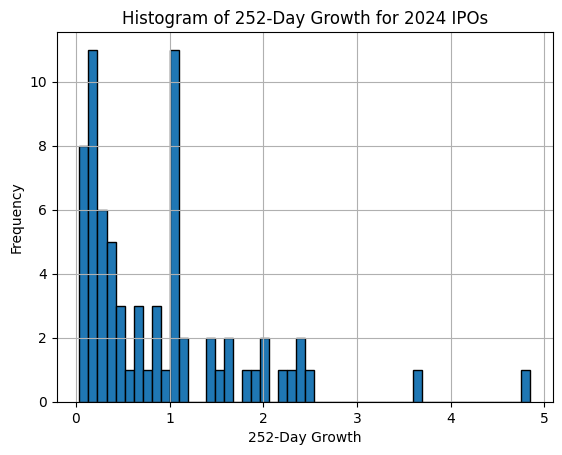

In [41]:
import matplotlib.pyplot as plt

ipo_data_cleaned['growth_252d'].hist(bins=50, edgecolor='black')
plt.xlabel('252-Day Growth')
plt.ylabel('Frequency')
plt.title('Histogram of 252-Day Growth for 2024 IPOs')
plt.show()

In [53]:
import financedatabase as fd

# Initialize the Equities database
equities = fd.Equities()

df_fd_data = equities.select()

In [99]:
# Filter df_fd_data to rows where the index matches any Symbol in ipo_data_cleaned
df_extra_info = df_fd_data[df_fd_data.index.isin(ipo_data_cleaned['Symbol'])]

In [117]:
df_extra_info.head(5)

,name,summary,currency,sector,industry_group,industry,exchange,market,country,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
symbol,,,,,,,,,,,,,,,,,,,
AHR,American Healthcare REIT Inc. Common Stock,American Healthcare REIT Inc. is a real estate...,USD,Real Estate,Real Estate,Equity Real Estate Investment Trusts (REITs),ASE,NYSE MKT,NaN,NaN,NaN,NaN,NaN,Mid Cap,NaN,NaN,NaN,NaN,NaN
ALAB,Astera Labs Inc. Common Stock,Astera Labs Inc. is a fabless semiconductor co...,USD,Information Technology,Semiconductors & Semiconductor Equipment,NaN,NMS,NASDAQ Global Select,United States,NaN,NaN,NaN,NaN,Large Cap,NaN,NaN,NaN,NaN,NaN
ANRO,Alto Neuroscience Inc.,"Alto Neuroscience, Inc. is a clinical-stage bi...",USD,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",NaN,ASE,NYSE MKT,NaN,NaN,NaN,NaN,NaN,Micro Cap,NaN,NaN,NaN,NaN,NaN
AS,Amer Sports Inc. Ordinary Shares,Amer Sports Inc. is a sporting goods company w...,USD,Consumer Discretionary,Consumer Durables & Apparel,NaN,ASE,NYSE MKT,NaN,NaN,NaN,NaN,NaN,Large Cap,NaN,NaN,NaN,NaN,NaN
AUNA,Auna SA,Auna S.A. is a healthcare company that owns an...,USD,Health Care,Health Care Equipment & Services,NaN,ASE,NYSE MKT,Peru,NaN,NaN,NaN,NaN,Small Cap,NaN,NaN,NaN,NaN,NaN


In [103]:
ipo_data_extra_info = ipo_data_cleaned.join(df_extra_info, how='left', on='Symbol', lsuffix='_ipo', rsuffix='_fd')

In [116]:
ipo_data_extra_info.tail(5)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,IPO Date cleaned,growth_1d,growth_3d,growth_7d,...,state,city,zipcode,website,market_cap,isin,cusip,figi,composite_figi,shareclass_figi
220,"Jan 18, 2024",CCTG,CCSC Technology International Holdings Limited,$6.00,$1.08,-82.00%,2024-01-18,1.168831,1.267533,2.168831,...,NaN,NaN,NaN,NaN,Nano Cap,NaN,NaN,NaN,NaN,NaN
221,"Jan 18, 2024",PSBD,Palmer Square Capital BDC Inc.,$16.45,$14.20,-13.68%,2024-01-18,1.011118,1.016677,1.009883,...,NaN,NaN,NaN,NaN,Nano Cap,NaN,NaN,NaN,NaN,NaN
222,"Jan 12, 2024",SYNX,Silynxcom Ltd.,$4.00,$1.89,-52.75%,2024-01-12,1.011080,0.980609,0.798061,...,NaN,NaN,NaN,NaN,Nano Cap,NaN,NaN,NaN,NaN,NaN
223,"Jan 11, 2024",SDHC,Smith Douglas Homes Corp.,$21.00,$17.72,-15.62%,2024-01-11,0.991304,1.028986,1.077019,...,NaN,NaN,NaN,NaN,Small Cap,NaN,NaN,NaN,NaN,NaN
224,"Jan 9, 2024",ROMA,Roma Green Finance Limited,$4.00,$2.76,-31.00%,2024-01-09,1.362069,1.389655,0.382759,...,NaN,NaN,NaN,NaN,Micro Cap,NaN,NaN,NaN,NaN,NaN


In [113]:
ipo_data_extra_info.columns

Index(['IPO Date', 'Symbol', 'Company Name', 'IPO Price', 'Current', 'Return',
       'IPO Date cleaned', 'growth_1d', 'growth_3d', 'growth_7d', 'growth_30d',
       'growth_90d', 'growth_252d', 'volatility', 'Sharpe Ratio',
       'future_growth_1m', 'future_growth_2m', 'future_growth_3m',
       'future_growth_4m', 'future_growth_5m', 'future_growth_6m',
       'future_growth_7m', 'future_growth_8m', 'future_growth_9m',
       'future_growth_10m', 'future_growth_11m', 'future_growth_12m',
       'first_trading_date', 'log1p_growth_252d', 'name', 'summary',
       'currency', 'sector', 'industry_group', 'industry', 'exchange',
       'market', 'country', 'state', 'city', 'zipcode', 'website',
       'market_cap', 'isin', 'cusip', 'figi', 'composite_figi',
       'shareclass_figi'],
      dtype='object')

In [112]:
# Group by 'market_cap', calculate the number of companies and average 252-day growth
avg_growth_by_market_cap = (
    ipo_data_extra_info
    .dropna(subset=['market_cap', 'growth_252d'])
    .groupby('market_cap')
    .agg(
        num_companies=('Symbol', 'count'),
        avg_growth_252d=('growth_252d', 'mean')
    )
    .reset_index()
)

# Sort by average growth
avg_growth_by_market_cap.sort_values(by='avg_growth_252d', ascending=False, inplace=True)
avg_growth_by_market_cap

,market_cap,num_companies,avg_growth_252d
0,Large Cap,7,1.758727
2,Mid Cap,8,1.601936
4,Small Cap,8,1.436933
1,Micro Cap,17,0.718008
3,Nano Cap,31,0.490000


In [114]:
# Group by 'industry_group', calculate the number of companies and average 252-day growth
avg_growth_by_industry_group = (
    ipo_data_extra_info
    .dropna(subset=['industry_group', 'growth_252d'])
    .groupby('industry_group')
    .agg(
        num_companies=('Symbol', 'count'),
        avg_growth_252d=('growth_252d', 'mean')
    )
    .reset_index()
)

# Sort by average growth
avg_growth_by_industry_group.sort_values(by='avg_growth_252d', ascending=False, inplace=True)
avg_growth_by_industry_group

,industry_group,num_companies,avg_growth_252d
7,Energy,2,2.497355
2,Capital Goods,5,1.773490
3,Commercial & Professional Services,1,1.669082
10,Insurance,1,1.533613
11,Media & Entertainment,2,1.420945
5,Consumer Services,2,1.321224
6,Diversified Financials,5,1.136028
13,Real Estate,3,1.072591
0,Automobiles & Components,1,1.018401
8,Food & Staples Retailing,2,0.886491


In [111]:
# Group by 'sector', calculate the average 252-day growth and count of companies
avg_growth_by_sector = (
    ipo_data_extra_info
    .dropna(subset=['sector', 'growth_252d'])
    .groupby('sector')
    .agg(
        num_companies=('Symbol', 'count'),
        avg_growth_252d=('growth_252d', 'mean')
    )
    .reset_index()
)

#seems like Energy and industrial sectors perform better than others
avg_growth_by_sector.sort_values(by='avg_growth_252d', ascending=False, inplace=True)
avg_growth_by_sector

,sector,num_companies,avg_growth_252d
3,Energy,2,2.497355
6,Industrials,10,1.242350
8,Real Estate,3,1.072591
4,Financials,8,1.060628
0,Communication Services,4,1.044406
1,Consumer Discretionary,7,0.986361
2,Consumer Staples,2,0.886491
7,Information Technology,6,0.685094
5,Health Care,18,0.596219


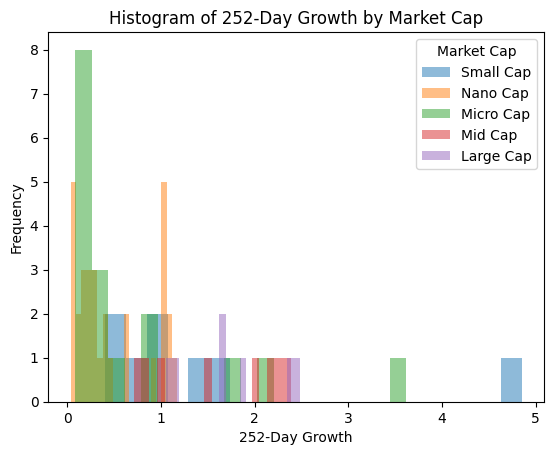

In [104]:
import matplotlib.pyplot as plt

# Drop rows with missing market_cap or growth_252d
plot_df = ipo_data_extra_info.dropna(subset=['market_cap', 'growth_252d'])

# Plot histogram for each market cap group
for cap in plot_df['market_cap'].unique():
    subset = plot_df[plot_df['market_cap'] == cap]
    plt.hist(subset['growth_252d'], bins=20, alpha=0.5, label=str(cap))

plt.xlabel('252-Day Growth')
plt.ylabel('Frequency')
plt.title('Histogram of 252-Day Growth by Market Cap')
plt.legend(title='Market Cap')
plt.show()

On top of the indicators, we can also look at the following:
1. Due diligence on the fundamentals 
2. Use market sentiments
3. Buy IPO based on rarity within given period (by market cap - large / small or by sector )
4. Pick the up and coming industry instead of sunset
5. Generative AI using trend / book from a succesful stock influencer
6. Gather key people trades - i.e. nancy pelosi
7. Insider trading - LOL im joking